In [4]:
from transformers import ViTImageProcessor, ViTModel
from qdrant_client import QdrantClient
from qdrant_client.http import models
from datasets import load_dataset
import numpy as np
import torch

In [5]:
client = QdrantClient(host="localhost", port=6333)

In [6]:
my_collection = "image_collection"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=384, distance=models.Distance.COSINE)
)

True

In [9]:
dataset = load_dataset("marmal88/skin_cancer", split='train')
dataset

Found cached dataset parquet (C:/Users/Duc.PM205068/.cache/huggingface/datasets/marmal88___parquet/marmal88--skin_cancer-4d80d9330324f110/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
    num_rows: 9577
})

In [15]:
dataset[8000]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450>,
 'image_id': 'ISIC_0033681',
 'lesion_id': 'HAM_0006235',
 'dx': 'melanocytic_Nevi',
 'dx_type': 'consensus',
 'age': 60.0,
 'sex': 'male',
 'localization': 'unknown'}

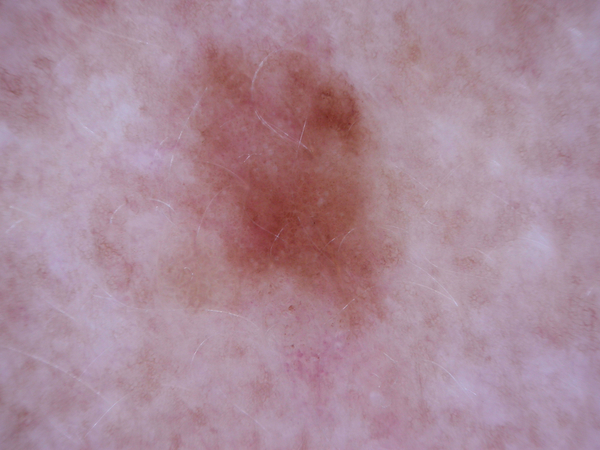

In [18]:
image = dataset[8000]["image"]
image

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = ViTImageProcessor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16').to(device)

preprocessor_config.json: 100%|██████████| 244/244 [00:00<00:00, 244kB/s]
c:\Users\Duc.PM205068\AppData\Local\anaconda3\envs\ai\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Duc.PM205068\.cache\huggingface\hub\models--facebook--dino-vits16. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
config.js

In [20]:
inputs = processor(images=image, return_tensors="pt").to(device)
inputs['pixel_values'].shape, inputs

(torch.Size([1, 3, 224, 224]),
 {'pixel_values': tensor([[[[ 0.3823,  0.4508,  0.4508,  ...,  0.4508,  0.4851,  0.5193],
           [ 0.3652,  0.4508,  0.4679,  ...,  0.5022,  0.5364,  0.5364],
           [ 0.3823,  0.4337,  0.4679,  ...,  0.5022,  0.5364,  0.5707],
           ...,
           [ 0.4851,  0.4851,  0.4508,  ...,  0.7248,  0.6906,  0.7077],
           [ 0.4508,  0.4679,  0.4679,  ...,  0.7248,  0.6906,  0.6906],
           [ 0.4508,  0.4337,  0.4337,  ...,  0.7248,  0.6906,  0.6734]],
 
          [[ 0.0301,  0.0826,  0.1352,  ...,  0.1527,  0.1877,  0.2227],
           [-0.0224,  0.1176,  0.1527,  ...,  0.1877,  0.2227,  0.2227],
           [-0.0574,  0.0826,  0.1527,  ...,  0.2052,  0.2402,  0.2752],
           ...,
           [ 0.1877,  0.1877,  0.1702,  ...,  0.4678,  0.4503,  0.4503],
           [ 0.1702,  0.1702,  0.1527,  ...,  0.4503,  0.3978,  0.3803],
           [ 0.1527,  0.1352,  0.1527,  ...,  0.4678,  0.3803,  0.3627]],
 
          [[ 0.5485,  0.6531,  0.6879,

In [21]:
one_embedding = model(**inputs).last_hidden_state
one_embedding.shape, one_embedding[0, 0, :20]

(torch.Size([1, 197, 384]),
 tensor([ 4.6516,  3.3129, -7.5305,  0.4937,  1.5112,  7.9089,  0.9562,  0.0222,
          4.8370, -0.2924,  1.9325,  6.1250,  2.1784,  3.2740,  0.3158, -1.0589,
          8.0359,  6.9333,  4.5831, -3.9526], grad_fn=<SliceBackward0>))

In [22]:
one_embedding.mean(dim=1).shape

torch.Size([1, 384])

In [23]:
def get_embeddings(batch):
    inputs = processor(images=batch['image'], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs).last_hidden_state.mean(dim=1).cpu().numpy()
    batch['embeddings'] = outputs
    return batch

In [24]:
dataset = dataset.map(get_embeddings, batched=True, batch_size=16)

Parameter 'function'=<function get_embeddings at 0x0000018BE1CA1B40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map:   0%|          | 0/9577 [00:00<?, ? examples/s]

In [25]:
dataset

Dataset({
    features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization', 'embeddings'],
    num_rows: 9577
})

In [26]:
np.save("vectors", np.array(dataset['embeddings']), allow_pickle=False)

In [27]:
payload = dataset.select_columns([
    "image_id", 'dx', 'dx_type', 'age', 'sex', 'localization'
]).to_pandas().fillna({"age": 0}).to_dict(orient="records")

payload[:3]

[{'image_id': 'ISIC_0024329',
  'dx': 'actinic_keratoses',
  'dx_type': 'histo',
  'age': 75.0,
  'sex': 'female',
  'localization': 'lower extremity'},
 {'image_id': 'ISIC_0024372',
  'dx': 'actinic_keratoses',
  'dx_type': 'histo',
  'age': 70.0,
  'sex': 'male',
  'localization': 'lower extremity'},
 {'image_id': 'ISIC_0024418',
  'dx': 'actinic_keratoses',
  'dx_type': 'histo',
  'age': 75.0,
  'sex': 'female',
  'localization': 'lower extremity'}]

In [28]:
ids = list(range(dataset.num_rows))
embeddings = np.load("vectors.npy").tolist()

In [29]:
batch_size = 500

for i in range(0, dataset.num_rows, batch_size):

    low_idx = min(i+batch_size, dataset.num_rows)

    batch_of_ids = ids[i: low_idx]
    batch_of_embs = embeddings[i: low_idx]
    batch_of_payloads = payload[i: low_idx]

    client.upsert(
        collection_name=my_collection,
        points=models.Batch(
            ids=batch_of_ids,
            vectors=batch_of_embs,
            payloads=batch_of_payloads
        )
    )

In [30]:
client.count(
    collection_name=my_collection, 
    exact=True,
)

CountResult(count=9577)

In [31]:
client.scroll(
    collection_name=my_collection,
    limit=5
)

([Record(id=0, payload={'age': 75.0, 'dx': 'actinic_keratoses', 'dx_type': 'histo', 'image_id': 'ISIC_0024329', 'localization': 'lower extremity', 'sex': 'female'}, vector=None, shard_key=None),
  Record(id=1, payload={'age': 70.0, 'dx': 'actinic_keratoses', 'dx_type': 'histo', 'image_id': 'ISIC_0024372', 'localization': 'lower extremity', 'sex': 'male'}, vector=None, shard_key=None),
  Record(id=2, payload={'age': 75.0, 'dx': 'actinic_keratoses', 'dx_type': 'histo', 'image_id': 'ISIC_0024418', 'localization': 'lower extremity', 'sex': 'female'}, vector=None, shard_key=None),
  Record(id=3, payload={'age': 50.0, 'dx': 'actinic_keratoses', 'dx_type': 'histo', 'image_id': 'ISIC_0024450', 'localization': 'upper extremity', 'sex': 'male'}, vector=None, shard_key=None),
  Record(id=4, payload={'age': 50.0, 'dx': 'actinic_keratoses', 'dx_type': 'histo', 'image_id': 'ISIC_0024463', 'localization': 'upper extremity', 'sex': 'male'}, vector=None, shard_key=None)],
 5)